# Exploratory data analysis (ETA) notebook

This notebook is dedicated to explore the dataset and define different features to be used in the model training step.

We will also use this exploration to motive our choice of the decision time t and horizon H.
In practice, both of these parameters would have extra motivation for their choice based on the business model and the company objectives. Here, however, we will motivate their choice purely based on data.

In [1]:
import sys
sys.path.append('..')  # Adjust the path as needed

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from src.read_data import * # Functions to read the data
from src.frame_creation import * # Functions to create dataframes from the data
from src.eda_plots import * # Functions to plot data exploration figures

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

We begin by loading three different tables from out database
    - allowlist: here we have a list of batches, user_ids and the data when each batch was allowed
    - loans: here we have a list of all loans, user_id, loan creation date, and loan update date
    - repayments: here we have a list of the loans that had any type of payment update (either principal repaiment or billing)

In [2]:
allowlist, loans, repayments = load_tables("../database.db")

In [3]:
batches = allowlist['batch'].unique() # List of batches 

Now we use the function loan_cum_frame to create a dataframe loan_CF.
This function allows us to merge the information in all three tables (allowlist, loans and repayments) and it returns to us a dataframe with all of their information + some new columns engineered from the data.

These new columns include the cumulative sum of the loan payments and billings, the evolution of the loan amount as the time passes due to interest rates, the lenght (in days) of each loan, and the time distance (in days) sicne the batch was allowed.

In [4]:
loan_CF = loan_cum_frame(allowlist, loans, repayments)

The function rebuild_CF_from_loan_CF is a helper function that takes the dataframe loan_CF (loan level) and transforms it in a different dataframe in batch level.

This dataframe is usefull to quickly plot the batch characteristics.

In [5]:
CF = rebuild_CF_from_loanCF(loan_CF)

In the next cell we plot the proportion of paid batches as the time passes, starting to count from when the batch was allowed.

We can clearly see that all of our 7 cohorts do not show very different curves, meaning that the speed for each their loans are paid is very similar. Batches 1 and 6 pay their loans a little quicker than the others, but not at a rate that I would say make them outliers.

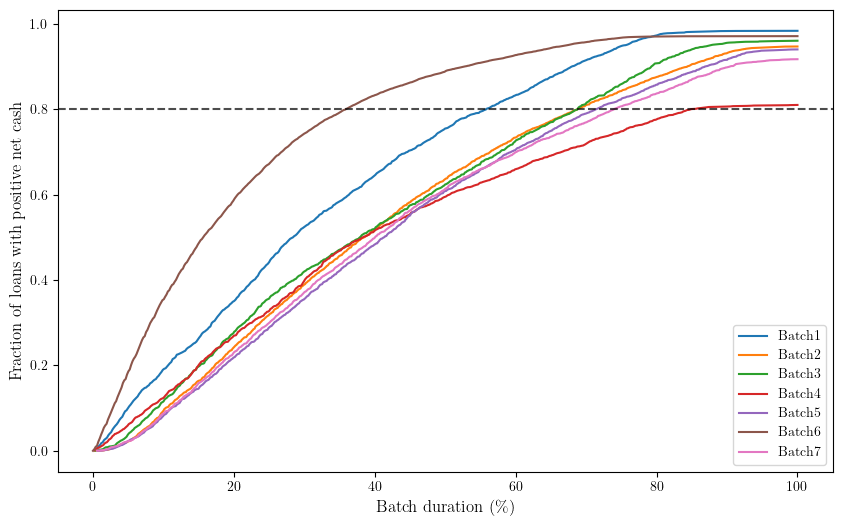

In [15]:
plt.figure(figsize=(10,6))
for i in range(len(batches)):

    batch_ = batches[i]
    res = day_when_loans_positive(0.8, loan_CF.query('batch == @batch_'), 'days_since_allowed')

    # res['prop_by_day'].plot(label = 'Batch' + str(i+1))
    plt.plot((res['prop_by_day'].reset_index()['first_positive_day']/res['prop_by_day'].reset_index()['first_positive_day'].max()) * 100, res['prop_by_day'].reset_index()['prop_positive'], label = 'Batch' + str(i+1))

plt.axhline(0.8, color='black', ls='--', alpha=0.7)
plt.xlabel('Batch duration (\%)', fontsize = 12)
plt.ylabel(r'Fraction of loans with positive net cash', fontsize = 12)
# plt.title(r'Tempo até 50\% dos loans ficarem positivos')
plt.legend()
plt.savefig('Figures/'+'batch_paid_percentile.png', dpi = 300, format = 'png')
plt.show()


Bellow we investigate the distribution of loan amounts in all batches.
The batches do not share the same loan amount distribution. But here we can see a possible explanation on why Batches 1 and 6 have a faster loan payment speed: these batches are dominated by low value loans, probably making them much easier for the users to pay.

In [34]:
L = loans.merge(allowlist[['user_id','batch']], on='user_id', how='left')
L = L.drop(['status', 'updated_at'], axis = 1).drop_duplicates(keep = 'first')
L['date'] = L['created_at']
batch_map = {b: f'Batch {i+1}' for i, b in enumerate(batches)}

desc = (L[['batch','loan_id','loan_amount']]
        .drop_duplicates()
        .groupby('batch')['loan_amount']
        .describe())

# renomeia o índice e reordena exatamente como Batch 1..N
desc_renamed = desc.rename(index=batch_map).reindex([f'Batch {i+1}' for i in range(len(batches))])
desc_renamed

,count,mean,std,min,25%,50%,75%,max
batch,,,,,,,,
Batch 1,3183.0,247.154138,425.680250,8.0,50.0,50.0,250.0,8430.0
Batch 2,8335.0,3678.315364,3467.704651,13.0,1600.0,2500.0,4500.0,41600.0
Batch 3,3641.0,2293.079789,3761.001484,10.0,500.0,1200.0,2470.0,64900.0
Batch 4,4976.0,520.053308,383.055092,5.0,500.0,500.0,500.0,10270.0
Batch 5,6028.0,3726.512135,4238.268714,10.0,1500.0,2500.0,4200.0,53230.0
Batch 6,14750.0,247.325261,653.237203,10.0,50.0,50.0,150.0,15450.0
Batch 7,4468.0,3146.937959,2863.601906,20.0,1500.0,2250.0,3700.0,28540.0


Bellow I show the ROI for each batch as a function of time (date). 

We can see Batches 2, 5 and 7 as a different group from 1, 3, 4, 5 and 6. Batches 2, 5 and 7 are older, and the three of them were allowed in 2022. 

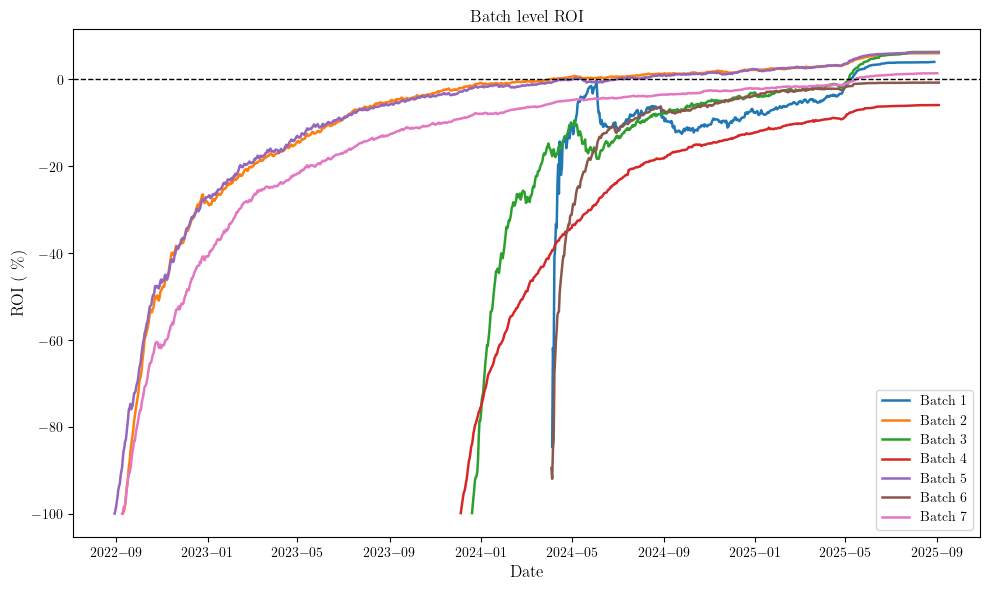

In [7]:
plt.figure(figsize=(10,6))

for i in range(len(batches)):
    # plt.plot(dfb['date'], dfb['roi_cum_batch_weighted']*100, lw=1.8, label=f'Weighted mean (loan_CF) — Batch {i}')

    c = CF[CF['batch'] == batches[i]].sort_values('date')
    plt.plot(c['date'], c['roi_cum']*100, lw=1.8, label='Batch ' + str(i + 1))

plt.axhline(0, color='k', ls='--', lw=1)
plt.xlabel('Date', fontsize = 12)
plt.ylabel(r'ROI ( \%)', fontsize = 12)
plt.title(r'Batch level ROI')
plt.tight_layout()
plt.legend()
plt.savefig('Figures/'+'batch_ROI_vs_date.png', dpi = 300, format = 'png')
plt.show()


I show again the ROI evolution of each batch, but this time the x axis represents the amount of days since the batch was allowed. Using the amount of days since the batch was allowed lets us compare all 7 batches more easily. We can see that, besides some larger fluctuations on batches 1 and 3 (blue and green), all the cohorts share a close/approximate behaviour.

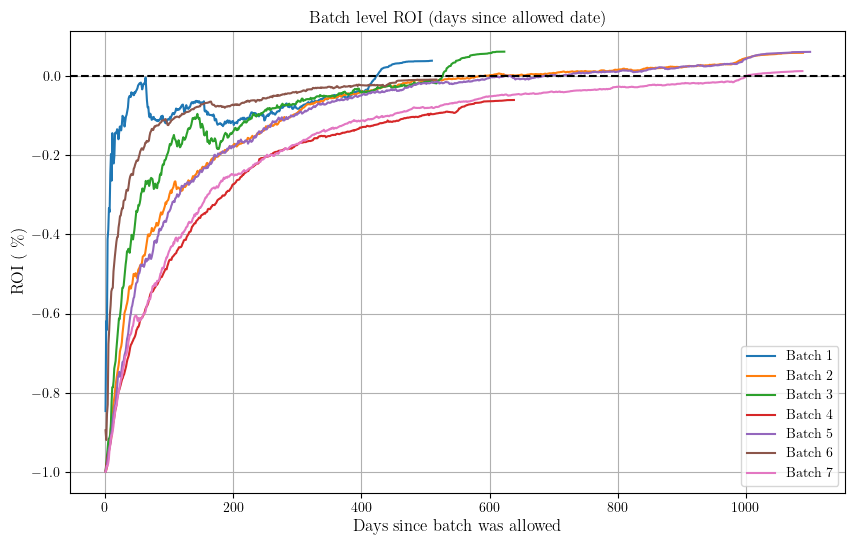

In [ ]:
plt.figure(figsize=(10,6))
for i in range(len(batches)):
    c = CF[CF['batch']==batches[i]]
    day_vec = np.linspace(1,(c['date'].max()- c['date'].min()).days, len(c['roi_cum']))
    plt.plot(day_vec, c['roi_cum'], label= 'Batch ' + str(i+1))
plt.axhline(0, color='k', ls='--'); plt.legend(); plt.grid()
# plt.title('ROI(t) acumulado — Top 5 batches por exposição')
plt.xlabel('Days since batch was allowed', fontsize = 12)
plt.ylabel(r'ROI ( \%)', fontsize = 12)
plt.title(r'Batch level ROI (days since allowed date)')
plt.savefig('Figures/'+'batch_ROI_vs_days.png', dpi = 300, format = 'png')
plt.show()

Bellow we have more plots showing the evolution of each batch, but this time, I show the evolution in loan level, where each curve represents one loan in the batch

Each figure has two plots: the upper plot shows the net cash for each loan, and the lower plot shows the ROI foi each loan.

  0%|          | 0/7 [00:00<?, ?it/s]

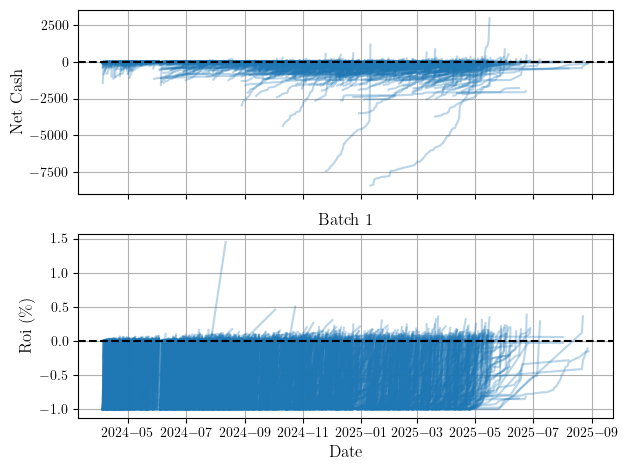

 14%|█▍        | 1/7 [00:13<01:18, 13.01s/it]

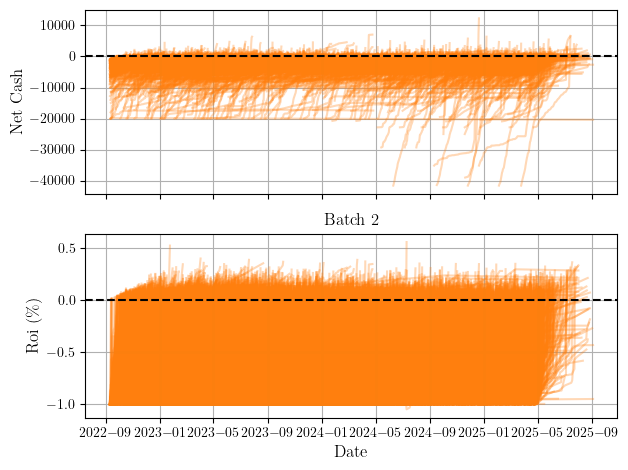

 29%|██▊       | 2/7 [02:10<06:11, 74.36s/it]

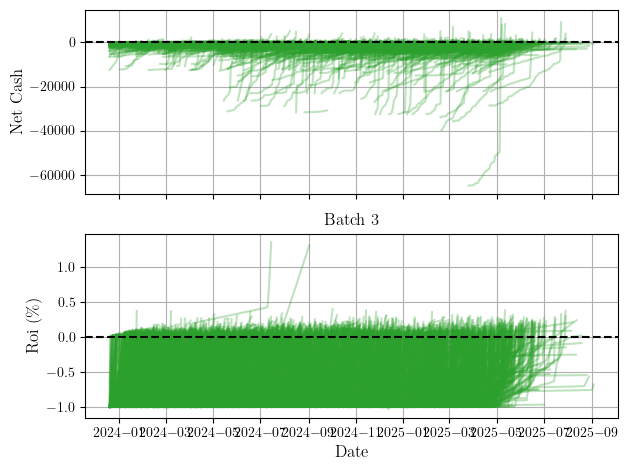

 43%|████▎     | 3/7 [02:32<03:22, 50.55s/it]

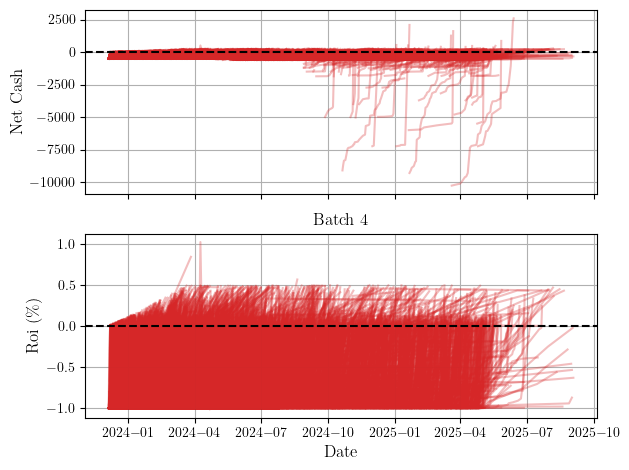

 57%|█████▋    | 4/7 [02:55<01:58, 39.52s/it]

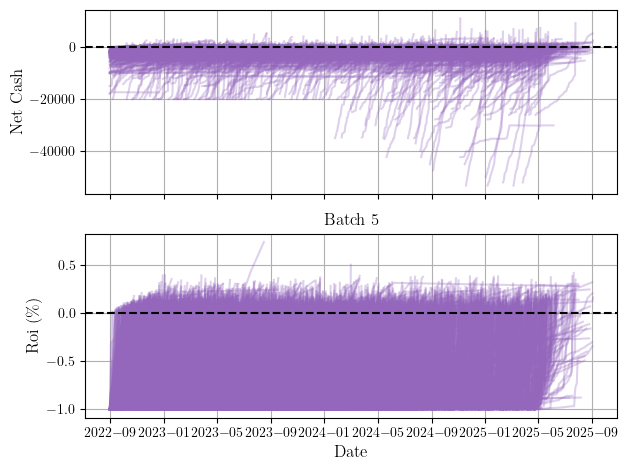

 71%|███████▏  | 5/7 [03:59<01:36, 48.49s/it]

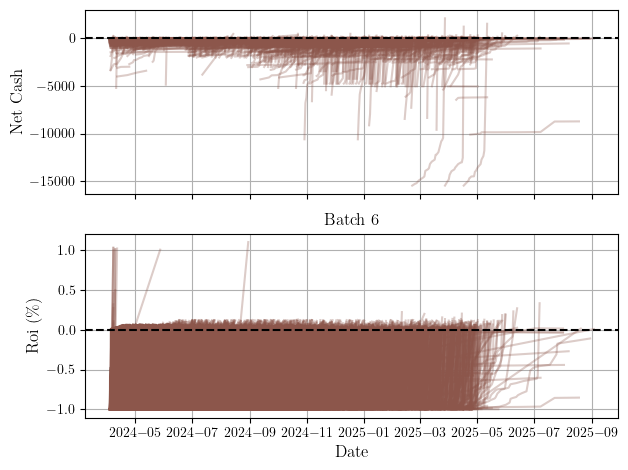

 86%|████████▌ | 6/7 [05:37<01:05, 65.20s/it]

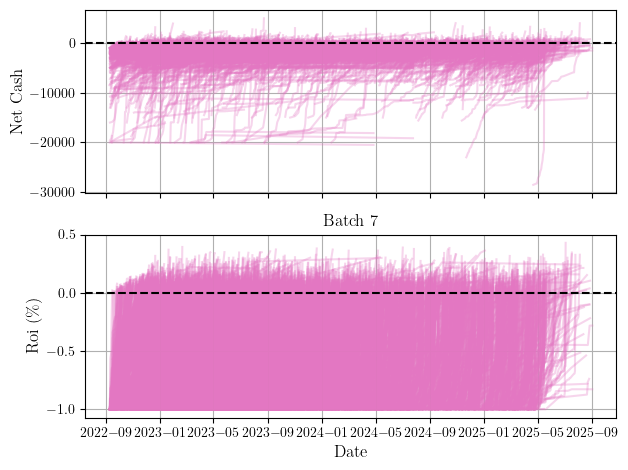

100%|██████████| 7/7 [06:14<00:00, 53.46s/it]


In [9]:
plot_batch_loan_history(loan_CF, batches)

And how the ROI of all batches behave since they were allowed?

For the plot bellow, I computed the average of all batches' ROIs with respect to time (days since allowed). I also computed the 90% CI (shared region). 

We can see that, on average, a batch is profitable (ROI > 0) after about 600 days of its creation.

We can also see that the slope of the ROI curve starts to slow down after about 100 days, and at 200 days it enters a "plateau" phase, increasing ever so slightly until it takes positive values. 

From this analysis, I chose to use the decision t as t=200 days. As for the horizon H, I chose to use H = 730 days (two years). This should be enough to allow us to find the ROI(H) using the least amount of days.

Of course, this choice could be changed based on business necessity. It could be the case that the business would allow us to wait for 365 days (one year) to make a decision if the batch is profitable or not. In these case, we would have more data and the prediction of ROI(H) would be more precise. In the same manner, it could also be that the business rules allows us to wait more for the batch profitability, lets say with H = 1000 days. Without access to any business rule and conditions, I made the safe and conservative choice of t = 200 and H = 730.

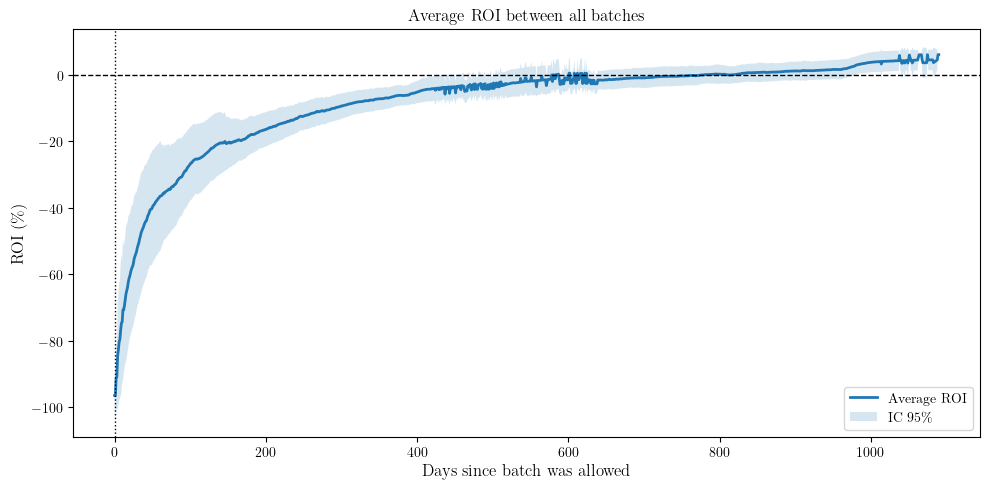

In [37]:
_ = plot_mean_roi_since_allow(loan_CF, rolling=None)

Next we compute a different version of loan_CF, called loan_CF_filtered.

The function remove_top_loans_per_batch removes the upper percentile 'p' of loans that have the largest loan amount. This is important so we can check if these outlier expensive loand can in fact change a low of the batch ROI.

In [16]:
loan_CF_filtered, removal_summary, batch_thresholds = remove_top_loans_per_batch(loan_CF,p=0.90)

Bellow we can see the same average ROI curve over all batches, filtered by the p90 percentile.

Not much changes, we only obtain a positive ROI slighly ealier. Before we had it at ~600 days, and now we have it at ~500 days.

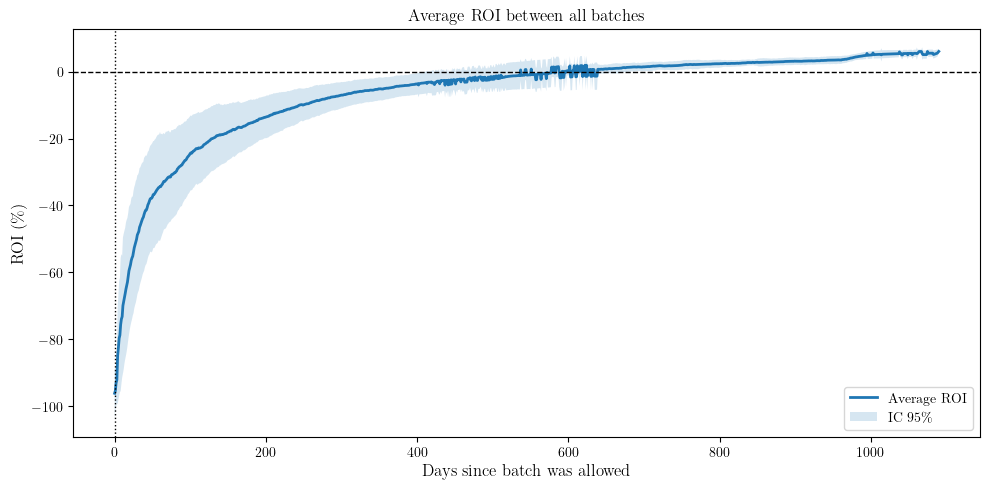

In [35]:
_ = plot_mean_roi_since_allow(loan_CF_filtered, rolling=None)

Bellow we also show again the plot of fraction of loans paid with respect of time for the new filtered dataframe. The curves do no change much once again.

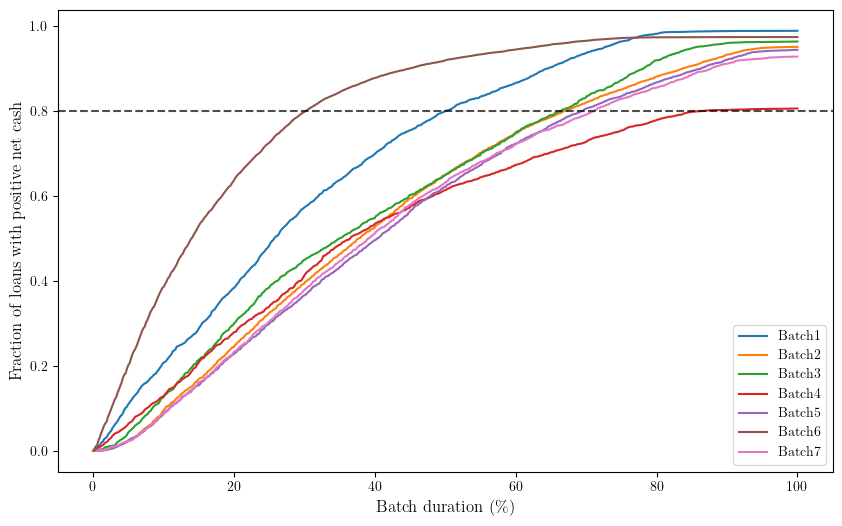

In [17]:
plt.figure(figsize=(10,6))
for i in range(len(batches)):

    batch_ = batches[i]
    res = day_when_loans_positive(0.8, loan_CF_filtered.query('batch == @batch_'), 'days_since_allowed')

    plt.plot((res['prop_by_day'].reset_index()['first_positive_day']/res['prop_by_day'].reset_index()['first_positive_day'].max()) * 100, res['prop_by_day'].reset_index()['prop_positive'], label = 'Batch' + str(i+1))

plt.axhline(0.8, color='black', ls='--', alpha=0.7)
plt.xlabel('Batch duration (\%)', fontsize = 12)
plt.ylabel(r'Fraction of loans with positive net cash', fontsize = 12)
# plt.title(r'Tempo até 50\% dos loans ficarem positivos')
plt.legend()
plt.savefig('Figures/'+'batch_filtered_paid_percentile.png', dpi = 300, format = 'png')
plt.show()


Lets see how the filter in loan amount changes each batch individually.

As a solid line we have the original dataframe, and in the dashed line we have the filtered one. It is clear that the net cash curve of each batch changes considerably, while the ROI curve has only a slight change. In both curves, however, we see that the batches crosses the threshold to become positive a few days earlier.

  0%|          | 0/7 [00:00<?, ?it/s]

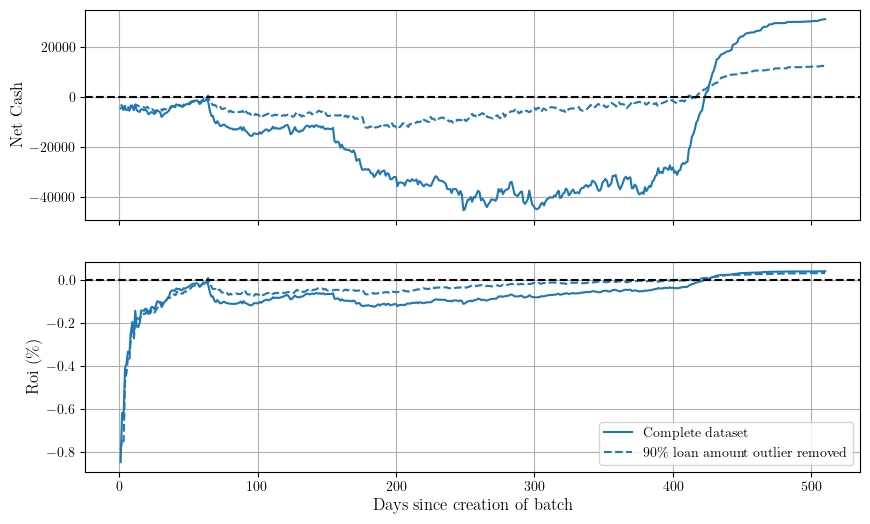

 14%|█▍        | 1/7 [00:02<00:12,  2.04s/it]

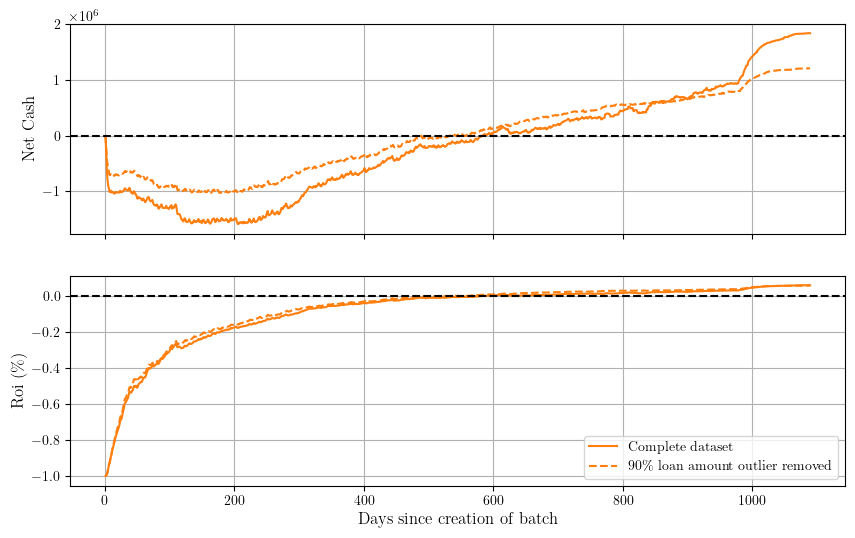

 29%|██▊       | 2/7 [00:03<00:09,  1.91s/it]

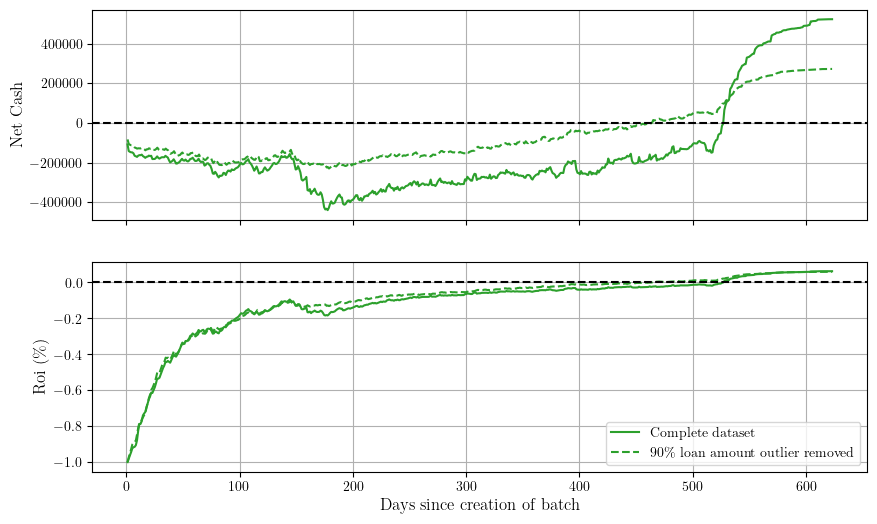

 43%|████▎     | 3/7 [00:05<00:07,  1.96s/it]

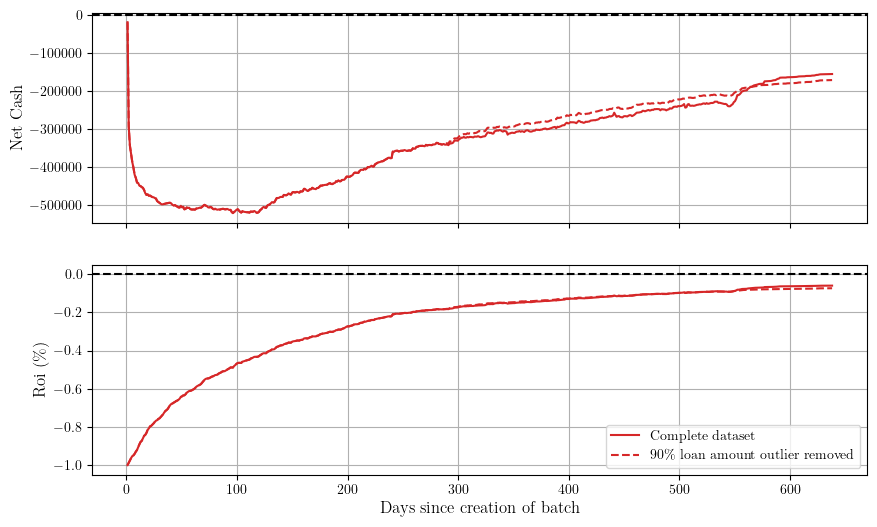

 57%|█████▋    | 4/7 [00:07<00:06,  2.01s/it]

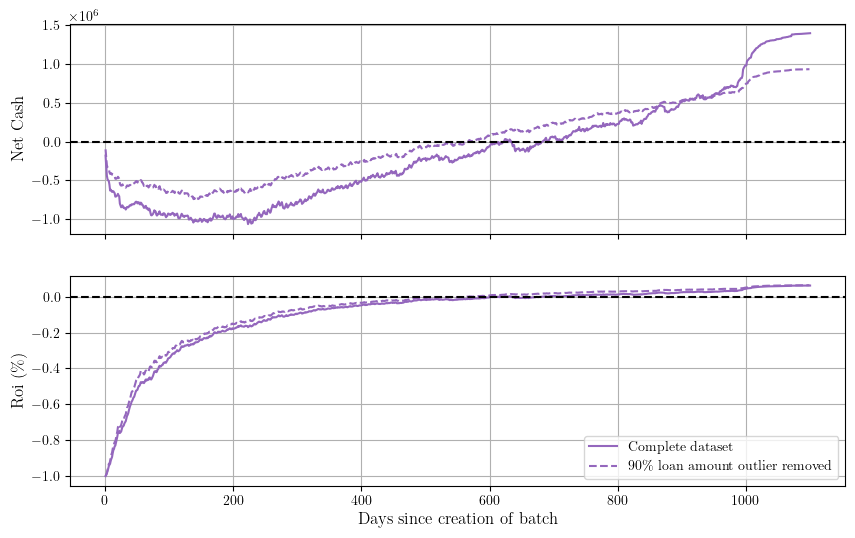

 71%|███████▏  | 5/7 [00:09<00:03,  1.82s/it]

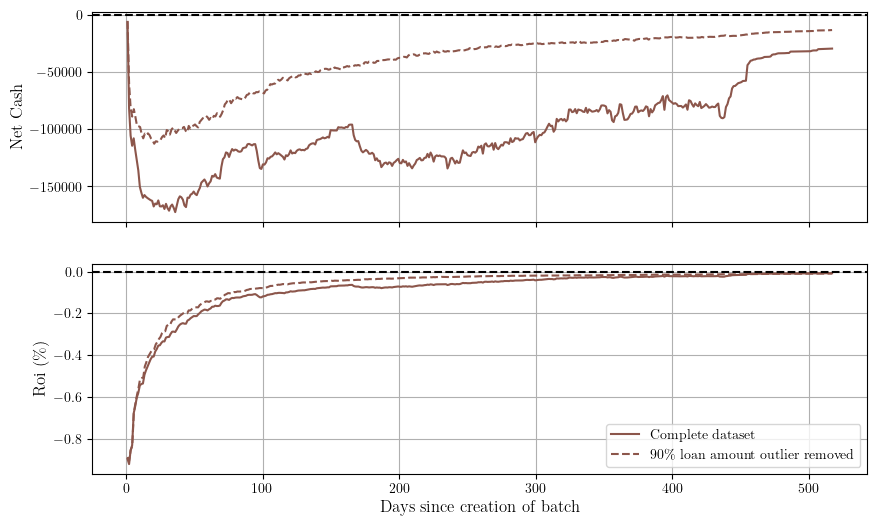

 86%|████████▌ | 6/7 [00:11<00:01,  1.81s/it]

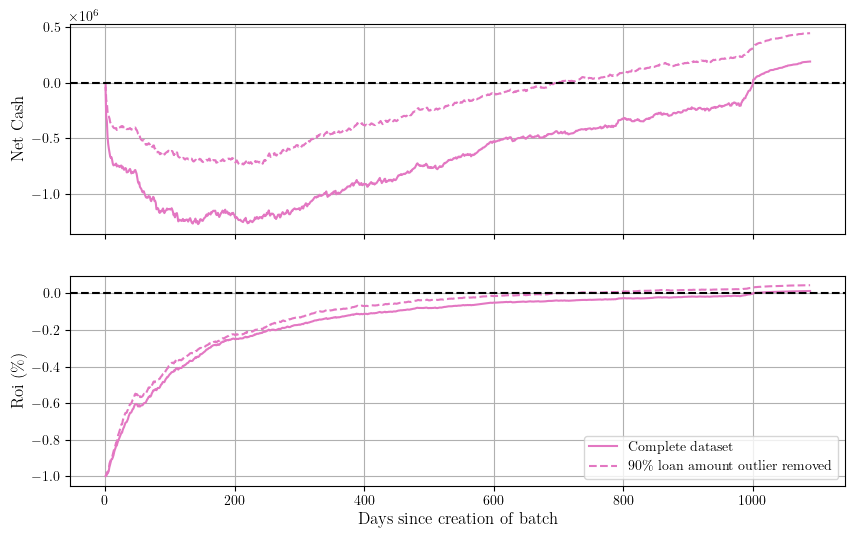

100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


In [40]:
CF_filtered = rebuild_CF_from_loanCF(loan_CF_filtered)
for i in tqdm(range(len(batches))):
    fig, axs = plt.subplots(2, sharex=True, figsize=(10,6))
    # CF_f_stop = cum_frame_filter(allowlist, loans, repayments, q = 90/100)

    c_f = CF_filtered[CF_filtered['batch']==batches[i]]
    day_vec_f = np.linspace(1,(c_f['date'].max()- c_f['date'].min()).days, len(c_f['roi_cum']))

    c = CF[CF['batch']==batches[i]]
    day_vec = np.linspace(1,(c['date'].max()- c['date'].min()).days, len(c['roi_cum']))

    axs[0].plot(day_vec, c.sort_values('date')['net_cash'], alpha = 1, color = list(mcolors.TABLEAU_COLORS.keys())[i], label = 'Complete dataset')
    axs[1].plot(day_vec, c.sort_values('date')['roi_cum'], alpha = 1, color = list(mcolors.TABLEAU_COLORS.keys())[i], label = 'Complete dataset')

    axs[0].plot(day_vec_f, c_f.sort_values('date')['net_cash'], alpha = 1, color = list(mcolors.TABLEAU_COLORS.keys())[i], linestyle = '--', label = r'90\% loan amount outlier removed')
    axs[1].plot(day_vec_f, c_f.sort_values('date')['roi_cum'], alpha = 1, color = list(mcolors.TABLEAU_COLORS.keys())[i], linestyle = '--', label = '90\% loan amount outlier removed')
    # net_cash.append(c[c['date'] <=dateH]['net_cash'].max())
    axs[0].axhline(0, color='k', ls='--')
    axs[1].axhline(0, color='k', ls='--')
    axs[0].grid()
    axs[1].grid()
    axs[0].set_ylabel(r'Net Cash', fontsize = 12)
    axs[1].set_ylabel(r'Roi (\%)', fontsize = 12)
    # plt.title('ROI(t) acumulado — Top 5 batches por exposição')
    plt.xlabel('Days since creation of batch', fontsize = 12)
    # plt.ylabel(r'Net Cash')
    plt.legend()

    for ax in axs:
        ax.label_outer()

    plt.savefig('Figures/' + 'Batch' + str(i+1) + '_complete_vs_filtered.png', dpi = 300, format = 'png')

    plt.show()

Lets investigate the day distributions of both dataframes.

Again, filtering out the top p90 loan amount loans only changes slightly the dataframe loan distributions.

The plots on the left show the distribution of loan lenght (in days). The plots on the right show the distribution of how long did it take for the loans to be made since the batch was allowed

  0%|          | 0/7 [00:00<?, ?it/s]

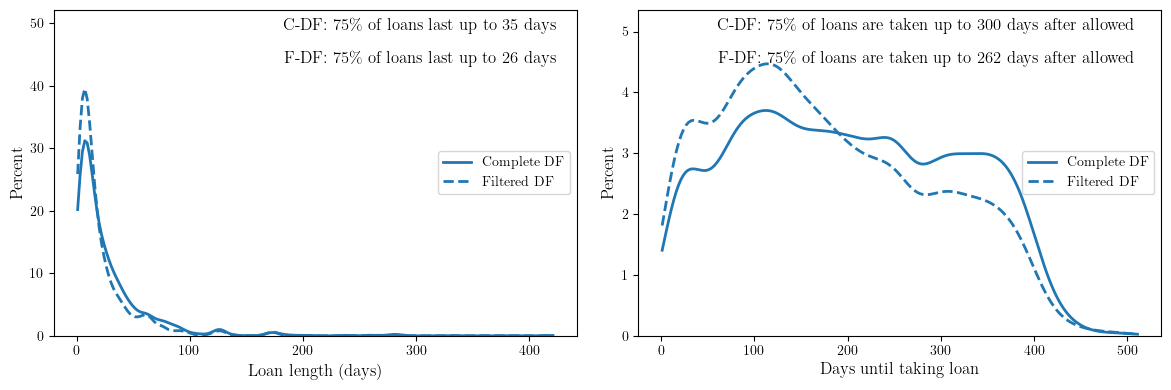

 14%|█▍        | 1/7 [00:01<00:06,  1.10s/it]

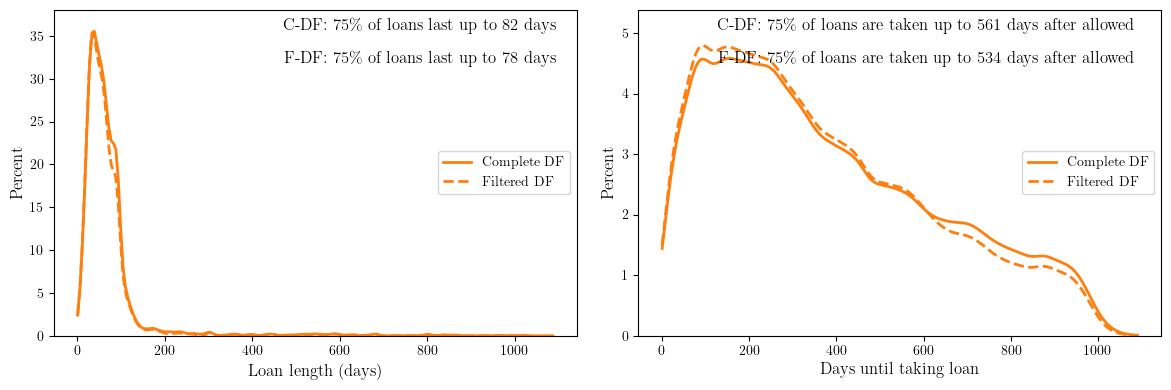

 29%|██▊       | 2/7 [00:06<00:18,  3.69s/it]

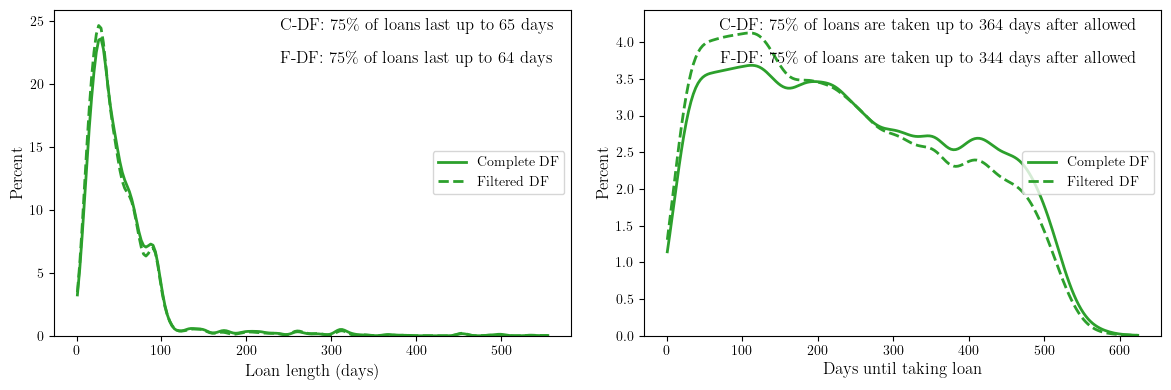

 43%|████▎     | 3/7 [00:08<00:11,  2.87s/it]

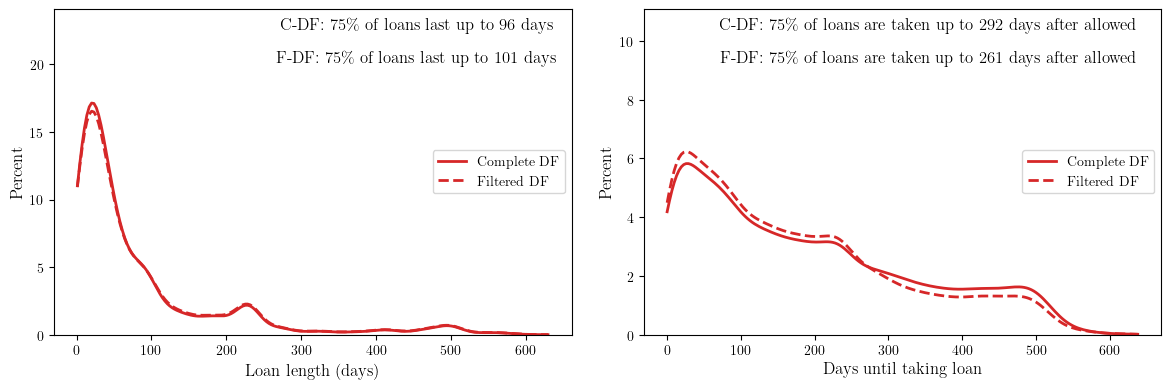

 57%|█████▋    | 4/7 [00:09<00:06,  2.17s/it]

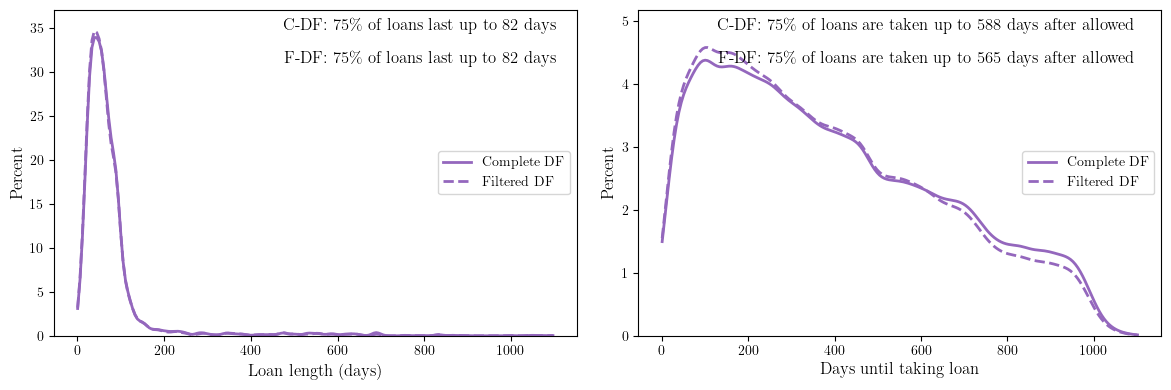

 71%|███████▏  | 5/7 [00:13<00:05,  2.75s/it]

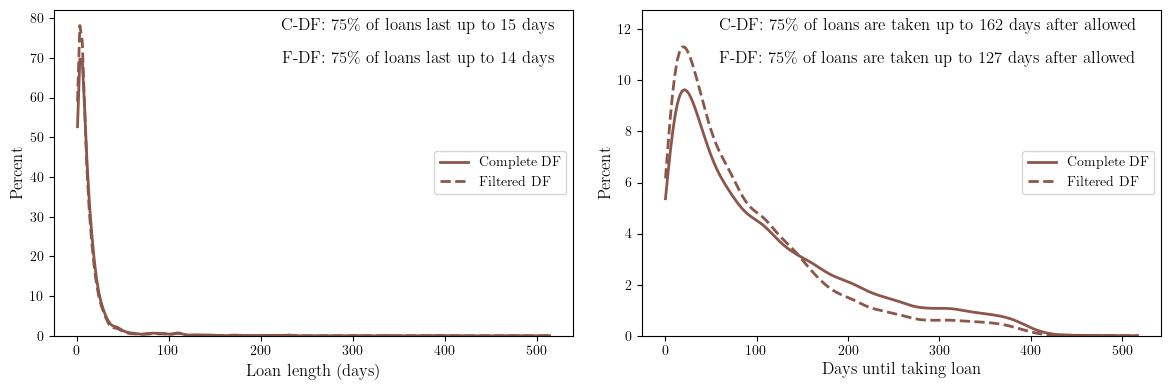

 86%|████████▌ | 6/7 [00:15<00:02,  2.38s/it]

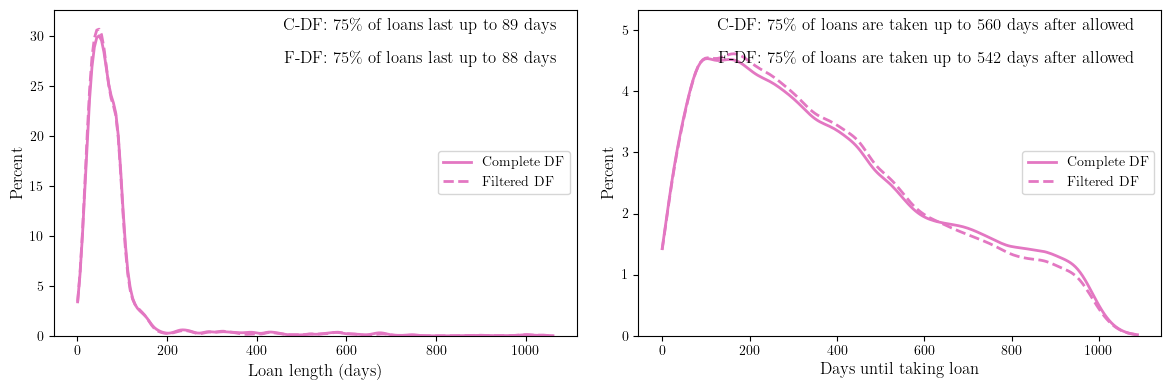

100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


In [41]:
plot_hist_days(loan_CF, loan_CF_filtered, batches)

Finnaly we are going to check for the correlation between our dataframe parameters

First we compute the correlation for the complete dataframe and show a heatmap plot of the correlation matrix.

It is clear that the largest correlations are given between the payment, billings and 'out' (how much each loan costs) and other money related quantities. However, we can also see correlation between the temporal features (days since batch was allowed and amount of days per loan in the dataset).

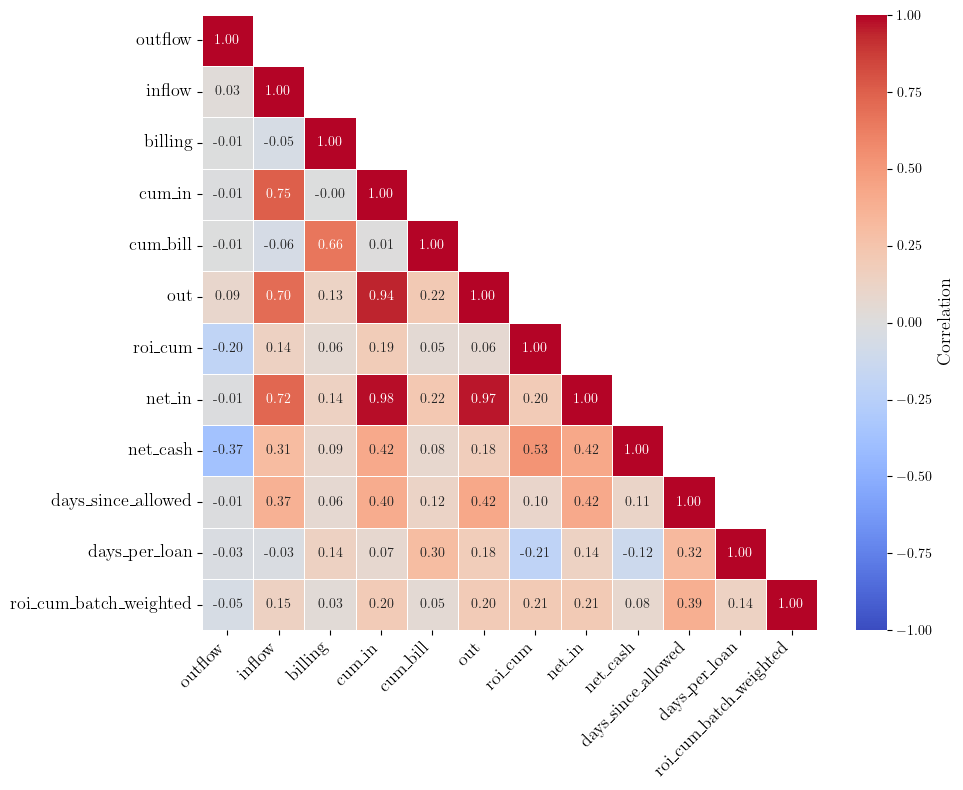

In [15]:
corr = corr_loan_params_final_day(loan_CF)

We compute the correlation matrix again for the filtered dataframe

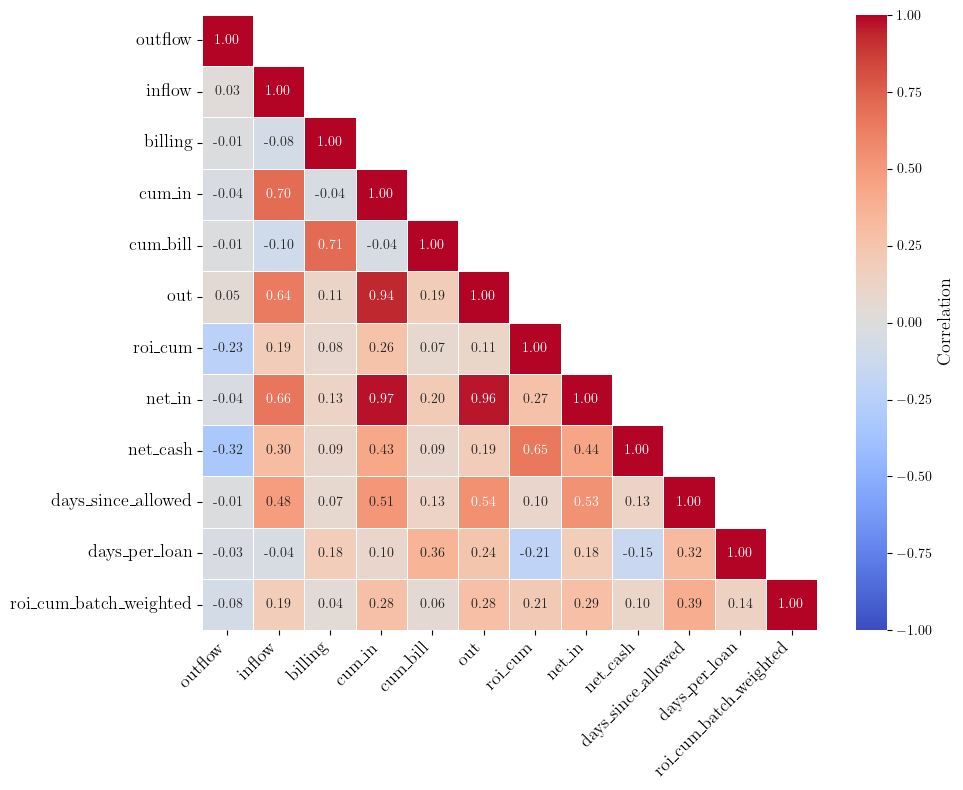

In [16]:
corr_filtered = corr_loan_params_final_day(loan_CF_filtered)

And bellow we check for the difference in correlation from the complete and the filtered dataframes.

Filtering out the most expensive loans does no change the correlation between our features. This indicates to us that the correlation between features is largely dominated by the 90% lower amount loans, and that the largest loans have more impact only on the time it takes for a batch to become profitable.

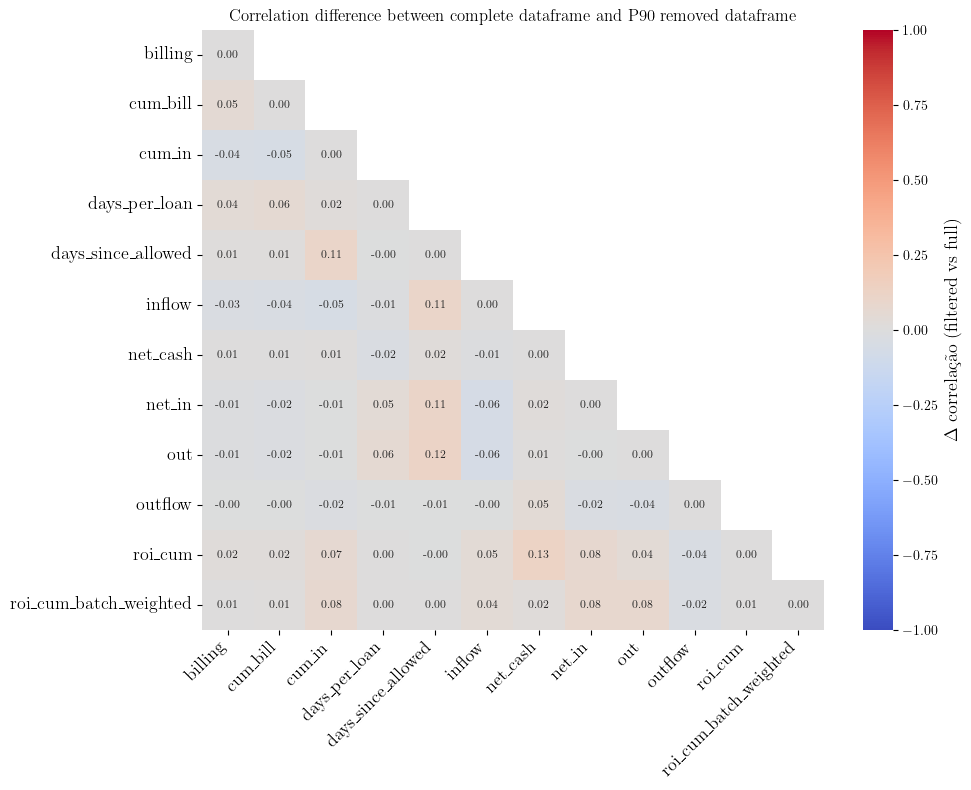

In [17]:
# 1) alinhar as matrizes nos mesmos eixos/ordem
common = sorted(set(corr.columns) & set(corr_filtered.columns))
C1 = corr.loc[common, common].copy()
C2 = corr_filtered.loc[common, common].copy()

# 2) diferença
delta = C2 - C1

# 3) heatmap da diferença
# plt.figure(figsize=(0.6*len(common)+3, 0.6*len(common)+3))
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    delta, mask = np.triu(np.ones_like(corr, dtype=bool), k=1), vmin=-1, vmax=1, center=0, cmap='coolwarm',
    annot=True, fmt=".2f", annot_kws={'size':8},
    cbar_kws={'label':r'$\Delta$ correlação (filtered vs full)'}
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.label.set_size(13)

ax.set_title('Correlation difference between complete dataframe and P90 removed dataframe')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
plt.tight_layout()
plt.show()